In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
import librosa
import torch
from pathlib import Path
from Models.vae import VAE
from datasets import WaveformDataset,SpectrogramDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [16]:
file_path = Path("/net/projects/scratch/summer/valid_until_31_January_2024/ybrima/data/learning/SyncSpeech/dataset_16k.npz")
# Load data
data = np.load(file_path, allow_pickle=True)
x = data['x']
y = data['y']
metadata = data['metadata'].tolist()
CLASSES = data['classes']

In [17]:
sample_rate = x[0].shape[0]
idx = np.random.randint(len(x))
print(f"Label: {CLASSES[y[idx]]}, Frequency = {metadata['freqs'][idx]} Hz, Amplitude = {metadata['amps'][idx]}")
Audio(x[idx], rate=sample_rate)

Label: sine, Frequency = 4911.578947368421 Hz, Amplitude = 1.0


In [18]:
train_dataset = WaveformDataset(x, y)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

x_batch, y_batch = next(iter(train_loader))
input_shape = x_batch.shape

In [19]:
x_batch, y_batch  = next(iter(train_loader))

In [65]:
latent_dim = 16
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = VAE(latent_dim, input_shape).to(device)
state_dict = torch.load('./Exports/vae.pth')

# Load state dict
vae.load_state_dict(state_dict)

with torch.inference_mode():
  x_hat, z_mean, z_logvar = vae(x_batch.to(device))
  # z_mean, z_logvar = vae.encode(x_batch.to(device))
  # z = vae.reparameterize(z_mean, z_logvar)
  # x_hat = vae.decode(z)

In [66]:
idx =  np.random.randint(len(x_hat))
Audio(x_hat[idx].squeeze().detach().cpu(), rate=sample_rate)

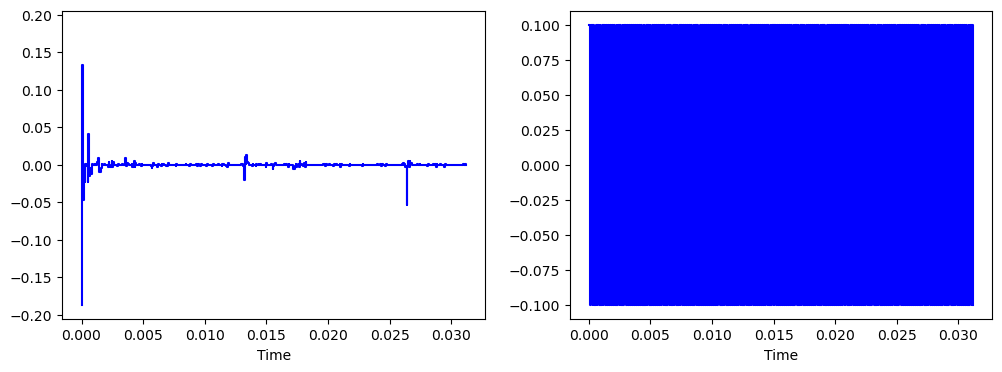

In [67]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
librosa.display.waveshow(x_hat[idx].squeeze().detach().cpu().numpy()[:500], sr=sample_rate, color='b' )
plt.subplot(1,2,2)
librosa.display.waveshow(x_batch[idx].squeeze().detach().cpu().numpy()[:500], sr=sample_rate, color='b')
plt.show()

In [27]:
print(f"Playing {CLASSES[y_batch[idx]]}")
Audio(x_batch[idx].squeeze().cpu(), rate=sample_rate)

Playing sine


In [28]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_sounds = vae.decode(latent_samples)  # Decode the latent samples


In [31]:
idx =  np.random.randint(len(generated_sounds))
Audio(generated_sounds[idx].squeeze().detach().cpu(), rate=sample_rate)

In [71]:
data = np.load(file_path, allow_pickle=True)
x = data['x']
y = data['y']

# Split data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Create dataset
train_dataset = SpectrogramDataset(x_train, y_train)
val_dataset = SpectrogramDataset(x_val, y_val)
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [72]:
x_batch,spec_batch, y_batch = next(iter(train_loader))
n = 2
idx = np.random.randint(len(x_batch), size=n)

In [105]:
import torch.nn.functional as F

class VAE2D(nn.Module):
    """Variational Autoencoder model for 2D data (e.g., spectrograms)."""

    def __init__(self, latent_dim, input_shape):
        super().__init__()

        _, num_channels, height, width = input_shape

        # Encoder
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Compute the size for fully connected layers dynamically
        fc_size = 32 * (height // 4) * (width // 4)
        self.flatten = nn.Flatten()
        self.fc_enc1 = nn.Linear(fc_size, 64)
        self.fc_enc2_mean = nn.Linear(64, latent_dim)
        self.fc_enc2_logvar = nn.Linear(64, latent_dim)

        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, 64)
        self.fc_dec2 = nn.Linear(64, fc_size)
        self.unflatten = nn.Unflatten(1, (32, height // 4, width // 4))
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, num_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Non-linearity
        self.neg_factor = 0.01

    def encode(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=self.neg_factor)
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x), negative_slope=self.neg_factor)
        x = self.pool(x)
        print(x.shape)
        x = self.flatten(x)
        x = F.leaky_relu(self.fc_enc1(x), negative_slope=self.neg_factor)

        z_mean = self.fc_enc2_mean(x)
        z_logvar = self.fc_enc2_logvar(x)

        return z_mean, z_logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        z = F.leaky_relu(self.fc_dec1(z), negative_slope=self.neg_factor)
        z = F.leaky_relu(self.fc_dec2(z), negative_slope=self.neg_factor)
        z = self.unflatten(z)
        # Print shape here to make sure it matches the shape of the encoder
        print(z.shape)
        z = F.leaky_relu(self.deconv1(z), negative_slope=self.neg_factor)
        x_hat = torch.tanh(self.deconv2(z))

        return x_hat

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_hat = self.decode(z)

        return x_hat, z_mean, z_logvar


In [124]:
import torch.nn.functional as F

class VAE2D(nn.Module):
    """Variational Autoencoder model for 2D data (e.g., spectrograms)."""

    def __init__(self, latent_dim, input_shape):
        super().__init__()

        _, num_channels, height, width = input_shape

        # Encoder
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Compute the size for fully connected layers dynamically
        fc_size = 32 * (height // 4) * (width // 4)
        self.flatten = nn.Flatten()
        self.fc_enc1 = nn.Linear(fc_size, 64)
        self.fc_enc2_mean = nn.Linear(64, latent_dim)
        self.fc_enc2_logvar = nn.Linear(64, latent_dim)

        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, 64)
        self.fc_dec2 = nn.Linear(64, fc_size)
        self.unflatten = nn.Unflatten(1, (32, height // 4, width // 4))
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1, output_padding=1, stride=2)
        self.deconv2 = nn.ConvTranspose2d(16, num_channels, kernel_size=3, padding=1, output_padding=1, stride=2)

        # Non-linearity
        self.neg_factor = 0.01

    def encode(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=self.neg_factor)
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x), negative_slope=self.neg_factor)
        x = self.pool(x)
        x = self.flatten(x)
        x = F.leaky_relu(self.fc_enc1(x), negative_slope=self.neg_factor)
        print(x.shape)
        z_mean = self.fc_enc2_mean(x)
        z_logvar = self.fc_enc2_logvar(x)
        
        return z_mean, z_logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        z = F.leaky_relu(self.fc_dec1(z), negative_slope=self.neg_factor)
        z = F.leaky_relu(self.fc_dec2(z), negative_slope=self.neg_factor)

        print(" z shape ", z.shape)
        z = self.unflatten(z)

        z = F.leaky_relu(self.deconv1(z), negative_slope=self.neg_factor)
        x_hat = torch.tanh(self.deconv2(z))

        return x_hat

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_hat = self.decode(z)

        return x_hat, z_mean, z_logvar


In [125]:
import torch

# Assuming input_shape is (num_channels, height, width)
input_shape = (1, 1, 513, 63)  # Adjust according to your actual input shape
latent_dim = 10

# Create a dummy input tensor
dummy_input = torch.randn(input_shape)

# Instantiate the model
model = VAE2D(latent_dim, input_shape)

# Pass the dummy input through the model
output, _, _ = model(dummy_input)

# Print the shapes of input and output
print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)


z_mean shape  torch.Size([1, 64])
 z shape  torch.Size([1, 61440])
Input shape: torch.Size([1, 1, 513, 63])
Output shape: torch.Size([1, 1, 512, 60])


In [73]:
spec_batch.shape 

torch.Size([64, 1, 513, 63])

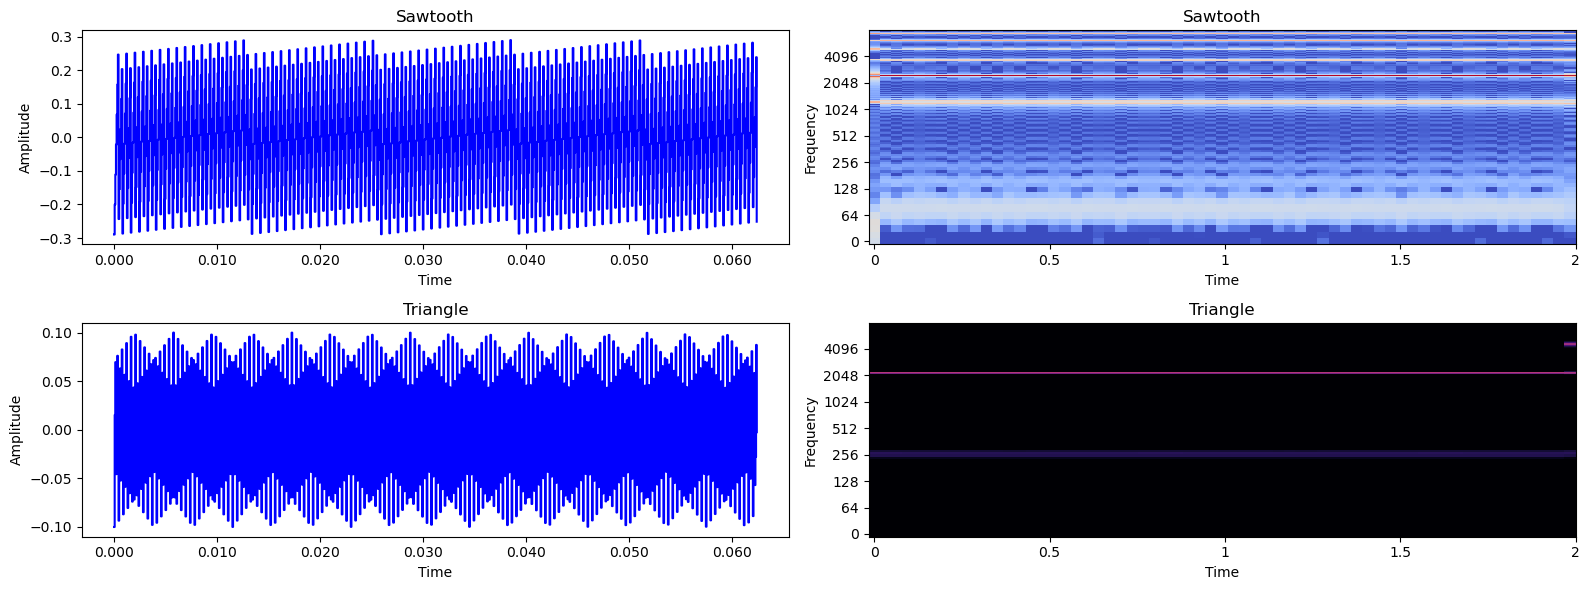

In [58]:

# Plot
fig, axs = plt.subplots(n, 2, figsize=(16,6))

for i in range(n):
  # Waveform 
  librosa.display.waveshow(x_batch[idx[i]].squeeze().detach().cpu().numpy()[:1000], sr=sample_rate, color='b', ax=axs[i, 0])
  # axs[i, 0].plot(x_batch[i].squeeze().detach().cpu().numpy())
  axs[i, 0].set_title(f'{CLASSES[y_batch[idx[i]]].capitalize() }')
  axs[i, 0].set_xlabel('Time')
  axs[i, 0].set_ylabel('Amplitude')

  # Spectrogram
  # axs[i, 1].imshow(librosa.power_to_db(spec_batch[idx[i]].squeeze().detach().cpu().numpy()), origin="lower", aspect="auto", interpolation="nearest")
  librosa.display.specshow(librosa.amplitude_to_db(spec_batch[idx[i]].squeeze().detach().cpu().numpy()),win_length=512, sr=sample_rate, x_axis='time', y_axis='log', ax=axs[i, 1])
  axs[i, 1].set_title(f'{CLASSES[y_batch[idx[i]]].capitalize() }')
  axs[i, 1].set_xlabel('Time')
  axs[i, 1].set_ylabel('Frequency')
plt.tight_layout()
# save the figure
# plt.savefig('./Figures/Samples.png', dpi=300)
plt.show()

In [105]:
# plt.rcParams.update({
#     'figure.facecolor': 'white',
#     'axes.facecolor': 'white', 
#     'axes.edgecolor': 'white',
#     'axes.labelcolor': 'white',
#     'xtick.color': 'white',
#     'ytick.color': 'white',
#     'text.color': 'white',
#     'savefig.facecolor': 'white',
#     'savefig.edgecolor': 'white'
# })

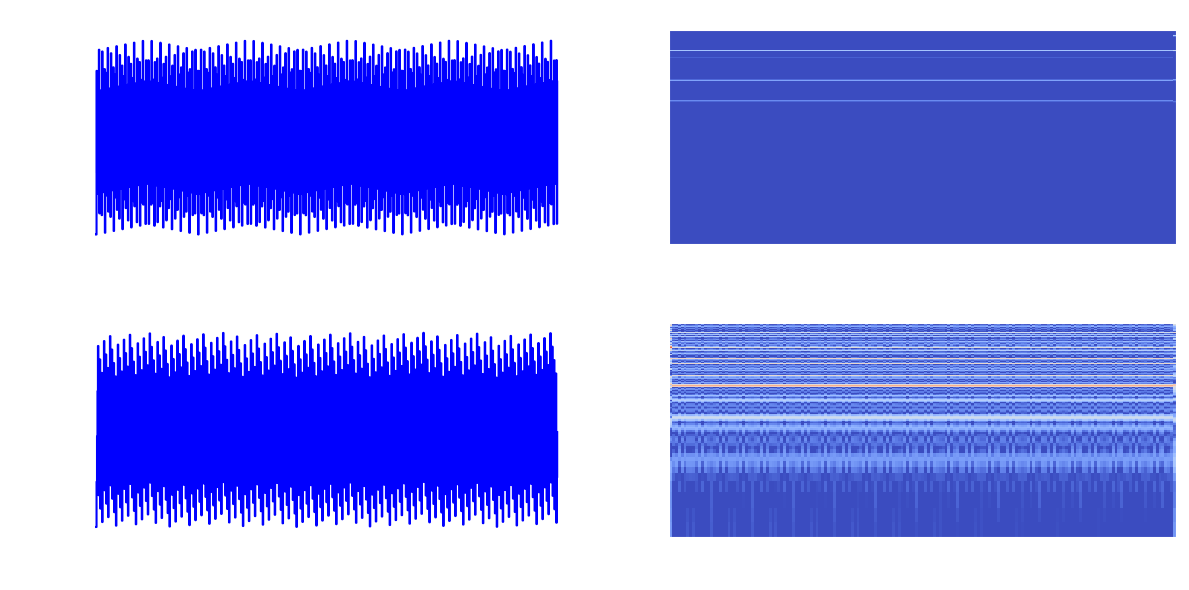

In [104]:
x_batch,spec_batch, y_batch = next(iter(train_loader))
n = 2
idx = np.random.randint(len(x_batch), size=n)
# Plot
fig, axs = plt.subplots(n, 2, figsize=(12,6))
# fig.patch.set_facecolor('none') 
for i in range(n):
  # Waveform 
  librosa.display.waveshow(x_batch[idx[i]].squeeze().detach().cpu().numpy()[:1000], sr=sample_rate, color='b', ax=axs[i, 0])
  # axs[i, 0].plot(x_batch[i].squeeze().detach().cpu().numpy())
  axs[i, 0].set_title(f'{CLASSES[y_batch[idx[i]]].capitalize() }')
  axs[i, 0].set_xlabel('Time')
  axs[i, 0].set_ylabel('Amplitude')

  # Spectrogram
  # axs[i, 1].imshow(librosa.power_to_db(spec_batch[idx[i]].squeeze().detach().cpu().numpy()), origin="lower", aspect="auto", interpolation="nearest")
  librosa.display.specshow(librosa.amplitude_to_db(spec_batch[idx[i]].squeeze().detach().cpu().numpy()),win_length=512, sr=sample_rate, x_axis='time', y_axis='log', ax=axs[i, 1])
  axs[i, 1].set_title(f'{CLASSES[y_batch[idx[i]]].capitalize() }')
  axs[i, 1].set_xlabel('Time')
  axs[i, 1].set_ylabel('Frequency')
plt.tight_layout()
# save the figure
plt.savefig('./Figures/Samples2.png', dpi=300, transparent=True)
plt.show()

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2,return_indices=True)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2,return_indices=True)
        
        self.fc_enc1 = nn.Linear(32 * 128 * 43, 64)
        self.fc_enc2_mean = nn.Linear(64, latent_dim)
        self.fc_enc2_logvar = nn.Linear(64, latent_dim)
        
        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, 64)
        self.fc_dec2 = nn.Linear(64, 32 * 128 * 43)
        
        self.unpool2 = nn.MaxUnpool2d(2,return_indices=True)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.unpool1 = nn.MaxUnpool2d(2,return_indices=True)
        self.deconv1 = nn.ConvTranspose2d(16, 1, kernel_size=5, padding=2)
        
        # Non-linearity
        self.neg_factor = 0.01
        
    def encode(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=self.neg_factor)
        x = self.pool1(x)
        x = F.leaky_relu(self.conv2(x), negative_slope=self.neg_factor)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        
        x = F.leaky_relu(self.fc_enc1(x), negative_slope=self.neg_factor)
        z_mean = self.fc_enc2_mean(x)
        z_logvar = self.fc_enc2_logvar(x)
        return z_mean, z_logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        z = F.leaky_relu(self.fc_dec1(z), negative_slope=self.neg_factor)
        z = F.leaky_relu(self.fc_dec2(z), negative_slope=self.neg_factor)
        z = z.view(-1, 32, 128, 43)
        
        z = self.unpool2(z)
        z = F.leaky_relu(self.deconv2(z), negative_slope=self.neg_factor)
        z = self.unpool1(z)
        x_hat = torch.tanh(self.deconv1(z))
        return x_hat
    
    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_hat = self.decode(z)
        return x_hat, z_mean, z_logvar

In [129]:
# Generate random of size torch.Size([64, 1, 513, 173])
X  = torch.randn(1, 1, 513, 173)
7500
cvae = CVAE(latent_dim).to(device)
x_hat, z_mean, z_logvar = cvae(X.to(device))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


torch.Size([1, 1, 512, 172])